In [62]:
import tensorflow as tf

import pathlib
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [47]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data preprocessing and exploration

### Download the Kaggle Credit Card Fraud data set

In [3]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### Clean, split and normalize the data

In [14]:
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps = 0.001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount') + eps)

In [15]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [19]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### Look at the data distribution

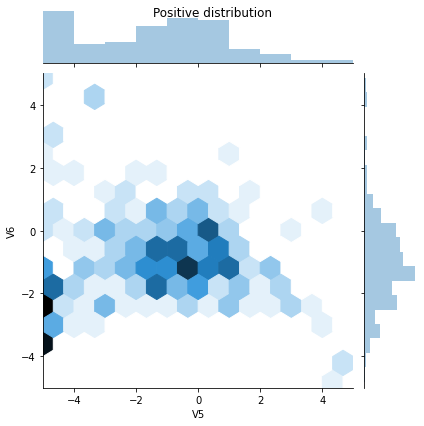

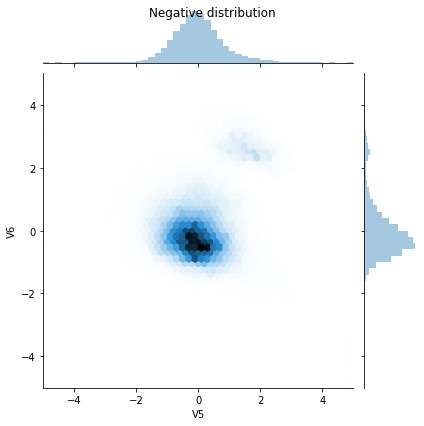

In [21]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
plt.suptitle('Positive distribution')

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
_ = plt.suptitle('Negative distribution')

## Define the model and metrics

In [23]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=[train_features.shape[-1], ]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,  activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

## Baseline model

In [24]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

In [25]:
model = make_model()

In [31]:
model.predict(train_features[:5])

array([[0.5272481 ],
       [0.47490945],
       [0.6630077 ],
       [0.52729416],
       [0.1604399 ]], dtype=float32)

### Set the correct initial bias

The correct bias to set can be derived from:

$p_0$ is initial guess probability of output.  
$b_0$ is initial bias.

$$
p_0 = \frac{pos}{pos+neg} = \frac{1}{1+e^{b_0}}\\
b_0 = - log_e (\frac{1}{p_0} - 1)\\
b_0 = log_e (\frac{pos}{neg})
$$

In [29]:
initial_bias = np.log([pos/neg])

In [32]:
model = make_model(output_bias=initial_bias)

Set that as the initial bias, and the model will give much more reasonable initial guesses. (positive samples is more less that. negative samples)

In [33]:
model.predict(train_features[:5])

array([[0.00175696],
       [0.00276824],
       [0.00173661],
       [0.00435012],
       [0.00799042]], dtype=float32)

### Checkpoint the initial weights

In [37]:
initial_weights = pathlib.Path(tempfile.mkdtemp())/'initial_weights'
model.save_weights(str(initial_weights))

### Confirm that the bias fix helps

In [41]:
model = make_model()
model.load_weights(str(initial_weights))
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(val_features, val_labels),
                              verbose=0)

In [43]:
model = make_model()
model.load_weights(str(initial_weights))
careful_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(val_features, val_labels),
                              verbose=0)

In [45]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

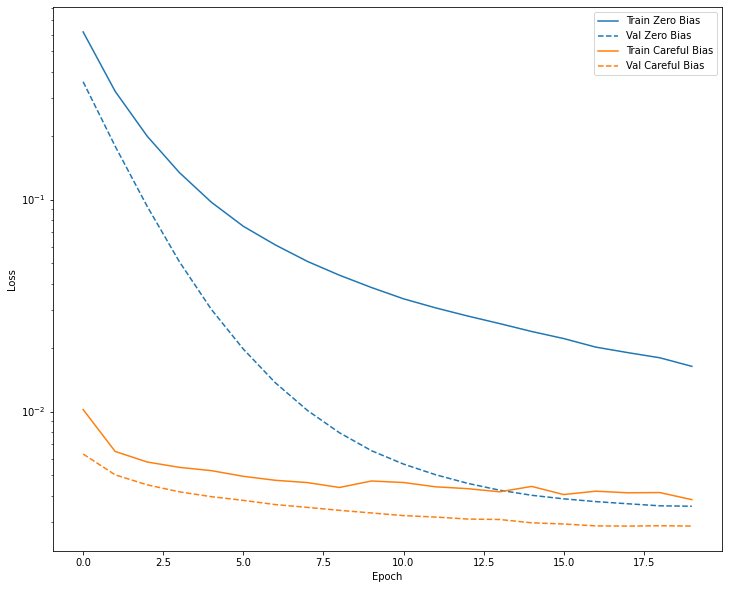

In [48]:
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

### Train the model

In [50]:
model = make_model()
model.load_weights(str(initial_weights))
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Epoch 1/10
90/90 [==============================] - 2s 17ms/step - loss: 0.0097 - tp: 119.0000 - fp: 23.0000 - tn: 227420.0000 - fn: 283.0000 - accuracy: 0.9987 - precision: 0.8380 - recall: 0.2960 - auc: 0.8480 - val_loss: 0.0063 - val_tp: 18.0000 - val_fp: 5.0000 - val_tn: 45485.0000 - val_fn: 61.0000 - val_accuracy: 0.9986 - val_precision: 0.7826 - val_recall: 0.2278 - val_auc: 0.9169
Epoch 2/10
90/90 [==============================] - 1s 6ms/step - loss: 0.0066 - tp: 130.0000 - fp: 21.0000 - tn: 181932.0000 - fn: 193.0000 - accuracy: 0.9988 - precision: 0.8609 - recall: 0.4025 - auc: 0.9122 - val_loss: 0.0050 - val_tp: 35.0000 - val_fp: 7.0000 - val_tn: 45483.0000 - val_fn: 44.0000 - val_accuracy: 0.9989 - val_precision: 0.8333 - val_recall: 0.4430 - val_auc: 0.9300
Epoch 3/10
90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 165.0000 - fp: 26.0000 - tn: 181927.0000 - fn: 158.0000 - accuracy: 0.9990 - precision: 0.8639 - recall: 0.5108 - auc: 0.9176 - val_lo

### Check training history

In [52]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

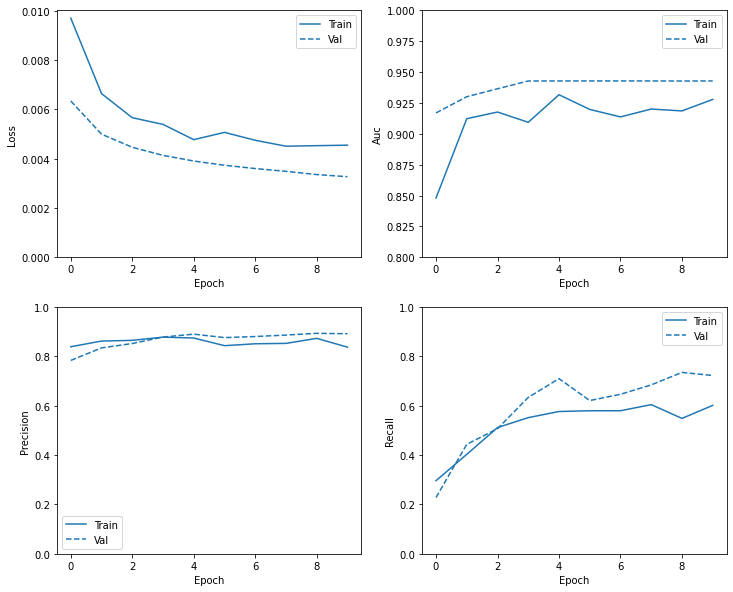

In [54]:
plot_metrics(baseline_history)

### Evaluate metrics

In [55]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [56]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0031504526268690825
tp :  71.0
fp :  11.0
tn :  56861.0
fn :  19.0
accuracy :  0.9994733333587646
precision :  0.8658536672592163
recall :  0.7888888716697693
auc :  0.9218934178352356

Legitimate Transactions Detected (True Negatives):  56861
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  90


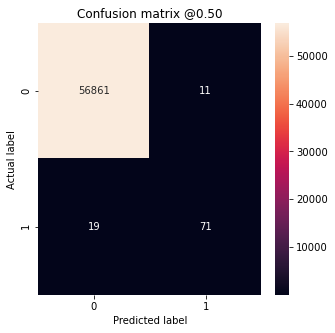

In [57]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### Plot the ROC

In [64]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

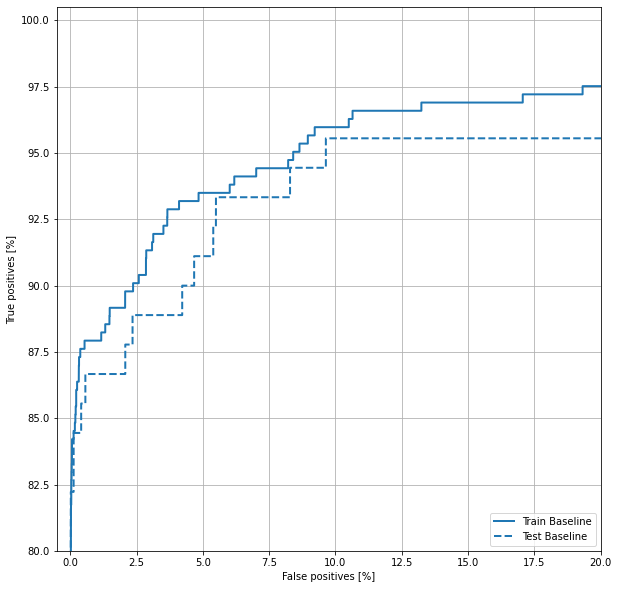

In [65]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Class weights

### Calculate class weights

In [81]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

In [83]:
weighted_model = make_model()
weighted_model.load_weights(str(initial_weights))

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/10
90/90 [==============================] - 1s 13ms/step - loss: 1.6188 - tp: 162.0000 - fp: 1064.0000 - tn: 237761.0000 - fn: 251.0000 - accuracy: 0.9945 - precision: 0.1321 - recall: 0.3923 - auc: 0.8444 - val_loss: 0.0071 - val_tp: 38.0000 - val_fp: 7.0000 - val_tn: 45483.0000 - val_fn: 41.0000 - val_accuracy: 0.9989 - val_precision: 0.8444 - val_recall: 0.4810 - val_auc: 0.9411
Epoch 2/10
90/90 [==============================] - 1s 6ms/step - loss: 0.8061 - tp: 184.0000 - fp: 221.0000 - tn: 181732.0000 - fn: 139.0000 - accuracy: 0.9980 - precision: 0.4543 - recall: 0.5697 - auc: 0.9102 - val_loss: 0.0090 - val_tp: 61.0000 - val_fp: 15.0000 - val_tn: 45475.0000 - val_fn: 18.0000 - val_accuracy: 0.9993 - val_precision: 0.8026 - val_recall: 0.7722 - val_auc: 0.9558
Epoch 3/10
90/90 [==============================] - 1s 6ms/step - loss: 0.5575 - tp: 227.0000 - fp: 489.0000 - tn: 181464.0000 - fn: 96.0000 - accuracy: 0.9968 - precision: 0.3170 - recall: 0.7028 - auc: 0.9260 - va

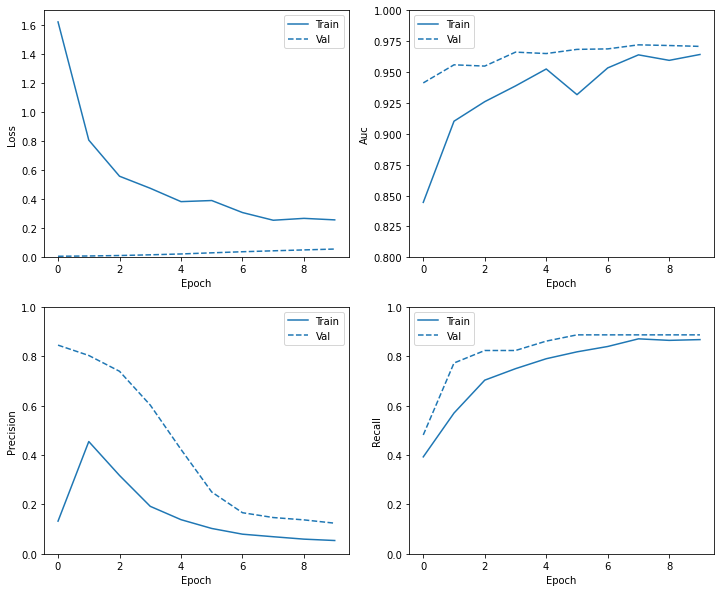

In [84]:
plot_metrics(weighted_history)

### Evaluate metrics

In [85]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.05951530858874321
tp :  78.0
fp :  679.0
tn :  56193.0
fn :  12.0
accuracy :  0.9878690838813782
precision :  0.10303831100463867
recall :  0.8666666746139526
auc :  0.9731534123420715

Legitimate Transactions Detected (True Negatives):  56193
Legitimate Transactions Incorrectly Detected (False Positives):  679
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  90


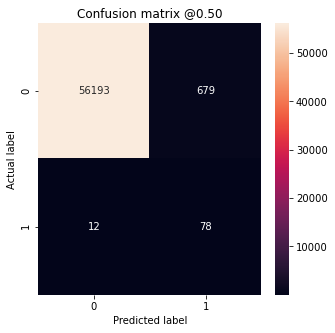

In [86]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

### Plot ROC

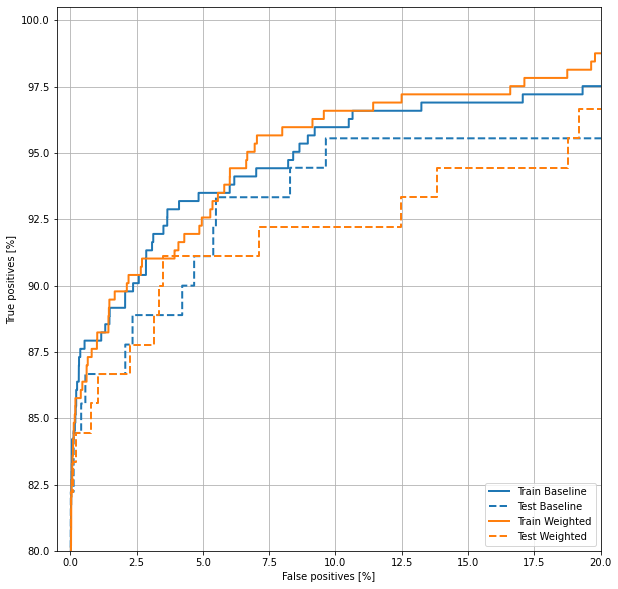

In [87]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

__Using Numpy__

In [66]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [67]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features)) # with replacement sampling positive samples

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181953, 29)

In [68]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# shuffle the data
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363906, 29)

__Using `tf.data`__

In [69]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels)).cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [70]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [72]:
# To use this dataset, you'll need to specify the number of steps per epoch.
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

In [76]:
resampled_model = make_model()
resampled_model.load_weights(str(initial_weights))

# Reset the bias to zero, since this dataset is balanced.
resampled_model.layers[-1] .bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS * 10,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 5s 19ms/step - loss: 0.3685 - tp: 253729.0000 - fp: 73441.0000 - tn: 256123.0000 - fn: 31620.0000 - accuracy: 0.8291 - precision: 0.7755 - recall: 0.8892 - auc: 0.9359 - val_loss: 0.2283 - val_tp: 72.0000 - val_fp: 1228.0000 - val_tn: 44262.0000 - val_fn: 7.0000 - val_accuracy: 0.9729 - val_precision: 0.0554 - val_recall: 0.9114 - val_auc: 0.9712
Epoch 2/100
278/278 [==============================] - 5s 17ms/step - loss: 0.1807 - tp: 260208.0000 - fp: 15038.0000 - tn: 269890.0000 - fn: 24208.0000 - accuracy: 0.9311 - precision: 0.9454 - recall: 0.9149 - auc: 0.9807 - val_loss: 0.1071 - val_tp: 72.0000 - val_fp: 885.0000 - val_tn: 44605.0000 - val_fn: 7.0000 - val_accuracy: 0.9804 - val_precision: 0.0752 - val_recall: 0.9114 - val_auc: 0.9701
Epoch 3/100
278/278 [==============================] - 4s 16ms/step - loss: 0.1360 - tp: 263734.0000 - fp: 10445.0000 - tn: 274438.0000 - fn: 20727.0000 - accuracy: 0.9452 - precision: 0.9619 -

### Check training history

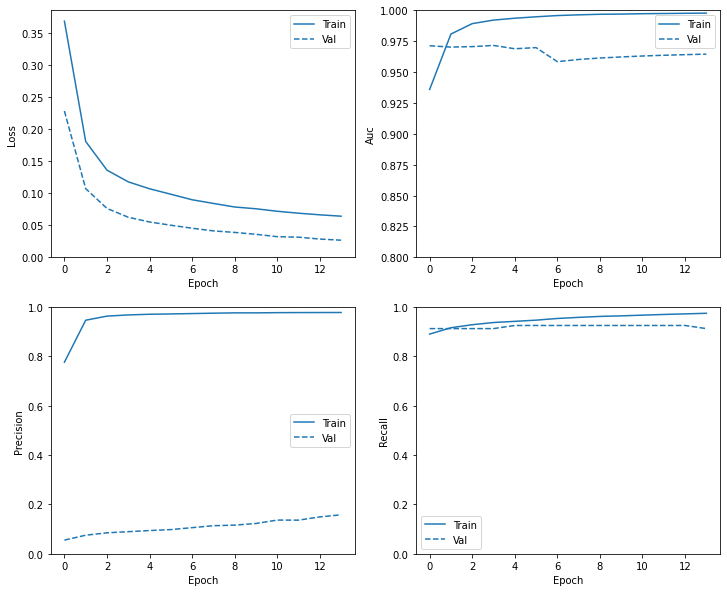

In [80]:
plot_metrics(resampled_history)

### Evaluate metrics

In [77]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.06361827999353409
tp :  80.0
fp :  975.0
tn :  55897.0
fn :  10.0
accuracy :  0.9827077984809875
precision :  0.0758293867111206
recall :  0.8888888955116272
auc :  0.9809746742248535

Legitimate Transactions Detected (True Negatives):  55897
Legitimate Transactions Incorrectly Detected (False Positives):  975
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  90


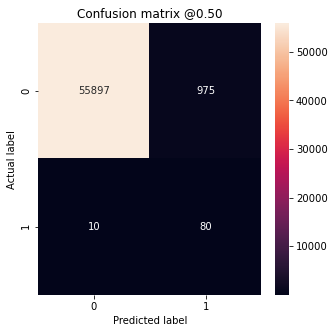

In [78]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

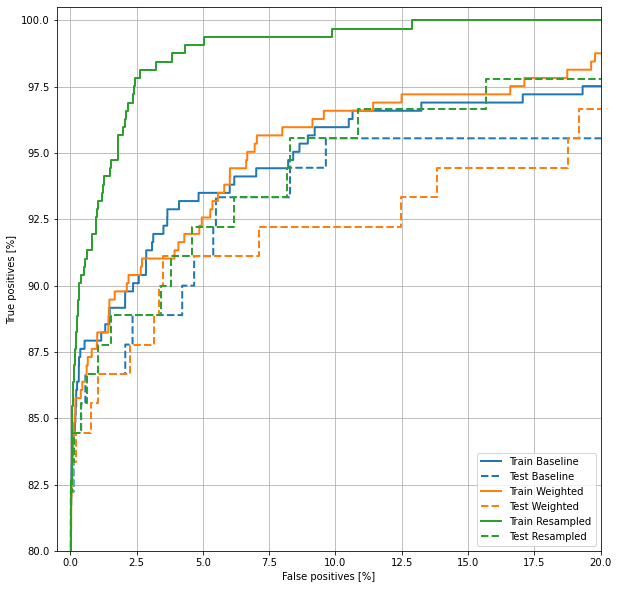

In [88]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')